In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import glob
import torch
import numpy as np
from PIL import Image
import torchvision.transforms.functional as F
from torch.utils.data import Dataset

class HistopathFolderDataset(Dataset):
    """
    - image_folder: 예) '/content/.../train/images'
    - mask_folder : 예) '/content/.../train/masks'
    - 파일명: 'train_1.bmp' / 'train_1_anno.bmp'
    - 이진화: mask>0 인 픽셀은 1로 바꾼다 (0,1 범위).
    """
    def __init__(self, image_folder, mask_folder, resize=(512,512)):
        super().__init__()
        self.image_folder = image_folder
        self.mask_folder  = mask_folder
        self.resize       = resize

        # 이미지 경로 수집
        self.image_paths = sorted(glob.glob(os.path.join(self.image_folder, '*.bmp')))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        # base_name: 'train_1'
        base_name = os.path.splitext(os.path.basename(img_path))[0]
        # mask_name: 'train_1_anno.bmp'
        mask_name = f"{base_name}_anno.bmp"
        mask_path = os.path.join(self.mask_folder, mask_name)

        # PIL 로드
        image = Image.open(img_path).convert('RGB')
        mask  = Image.open(mask_path)

        # Resize: 이미지 = Bilinear, 마스크 = NEAREST
        image = F.resize(image, self.resize, Image.BILINEAR)
        mask  = F.resize(mask,  self.resize, Image.NEAREST)

        # NumPy 변환 (예: [0,1,2,3,4,5,6,7,8,9] 등)
        mask = np.array(mask, dtype=np.int64)

        # ------------ 이진화 단계 ------------
        # 0이 아닌 모든 값을 1로 변환 (배경=0, 병변=1)
        mask[mask > 0] = 1
        # ----------------------------------

        # ToTensor
        image = F.to_tensor(image)                    # shape=[3,512,512], float
        mask  = torch.from_numpy(mask).long()         # shape=[512,512], long

        return image, mask

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[Epoch 1/20] train_loss=0.4725, val_loss=0.3464
[Epoch 2/20] train_loss=0.2866, val_loss=0.2971
[Epoch 3/20] train_loss=0.2150, val_loss=0.2212
[Epoch 4/20] train_loss=0.1553, val_loss=0.2482
[Epoch 5/20] train_loss=0.1436, val_loss=0.2087
[Epoch 6/20] train_loss=0.1265, val_loss=0.2089
[Epoch 7/20] train_loss=0.1213, val_loss=0.2191
[Epoch 8/20] train_loss=0.1038, val_loss=0.1977
[Epoch 9/20] train_loss=0.1102, val_loss=0.2232
[Epoch 10/20] train_loss=0.0922, val_loss=0.1955
[Epoch 11/20] train_loss=0.0943, val_loss=0.2364
[Epoch 12/20] train_loss=0.0771, val_loss=0.1931
[Epoch 13/20] train_loss=0.0676, val_loss=0.1903
[Epoch 14/20] train_loss=0.0612, val_loss=0.1892
[Epoch 15/20] train_loss=0.0554, val_loss=0.2059
[Epoch 16/20] train_loss=0.0519, val_loss=0.1962
[Epoch 17/20] train_loss=0.0485, val_loss=0.1910
[Epoch 18/20] train_loss=0.0473, val_loss=0.2037
[Epoch 19/20] train_loss=0.0415, val_loss=0.1986
[Epoch 20/20] train_loss=0.0410, val_loss=0.1979


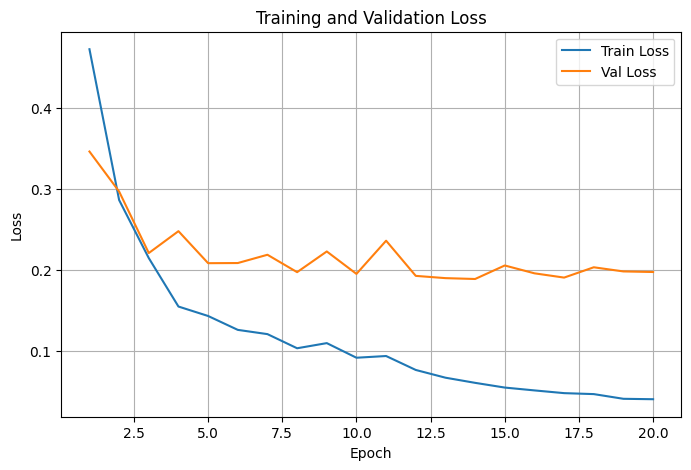

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

#######################
# 1) 데이터 로드 세팅
#######################
root_dir = "/content/drive/MyDrive/Pathology_WSI_SegDet/Warwick_filtered_Dataset"

train_img_dir  = os.path.join(root_dir, "train", "images")
train_msk_dir  = os.path.join(root_dir, "train", "masks")
testA_img_dir  = os.path.join(root_dir, "testA", "images")
testA_msk_dir  = os.path.join(root_dir, "testA", "masks")

train_dataset = HistopathFolderDataset(train_img_dir, train_msk_dir, resize=(512,512))
testA_dataset = HistopathFolderDataset(testA_img_dir, testA_msk_dir, resize=(512,512))

train_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=2,
    drop_last=True
)
testA_loader = DataLoader(
    testA_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=2
)

#######################
# 2) 모델 및 학습 파라미터
#######################
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)
model.classifier[4] = nn.Conv2d(256, 2, kernel_size=1)  # 2-class output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ---- LR Scheduler: ReduceLROnPlateau ----
# - patience=3: 검증 손실이 3 epoch 연속 개선되지 않으면 학습률을 factor 배로 줄임
# - factor=0.5 : 학습률을 절반으로
# - verbose=True: 줄어드는 과정을 로그로 표시
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    verbose=True
)

num_epochs = 20  # 예시: 20 epoch

#######################
# 3) 학습/검증 함수
#######################
def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)

def validate_one_epoch(model, dataloader, criterion):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            val_loss += loss.item()
    return val_loss / len(dataloader)

#######################
# 4) 학습 루프 + 손실값 기록
#######################
train_losses = []
val_losses   = []

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss   = validate_one_epoch(model, testA_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"[Epoch {epoch+1}/{num_epochs}] train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")

    # 스케줄러에 검증 손실 전달 -> 개선 안 되면 LR 감소
    scheduler.step(val_loss)

#######################
# 5) Loss 그래프 시각화
#######################
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

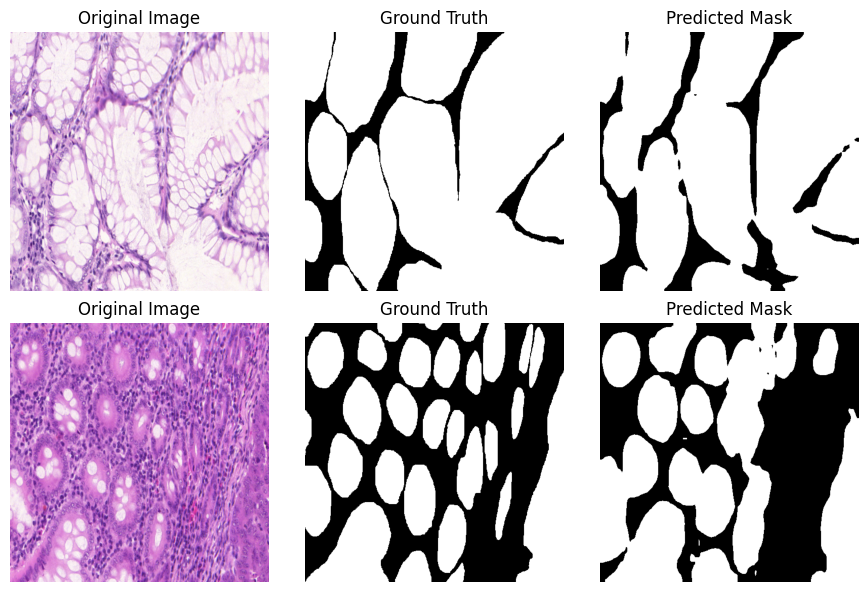

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 배치 하나를 뽑아 추론
model.eval()
images, true_masks = next(iter(testA_loader))  # 예: testA_loader
images, true_masks = images.to(device), true_masks.to(device)

with torch.no_grad():
    outputs = model(images)['out']  # (N,2,H,W) for 2-class
    preds = torch.argmax(outputs, dim=1)  # (N,H,W)

# CPU로 옮기기
images     = images.cpu()
true_masks = true_masks.cpu()
preds      = preds.cpu()

# 배치 크기
batch_size = images.size(0)

# (원본, GT, 예측) 3개씩 시각화
fig, axs = plt.subplots(batch_size, 3, figsize=(9, 3 * batch_size))

# 만약 batch_size == 1이면 axs 형태를 맞춰주기 위해
if batch_size == 1:
    axs = [axs]

for i in range(batch_size):
    # 원본 이미지: [C,H,W] -> [H,W,C] 로 변환
    image_np = np.transpose(images[i].numpy(), (1, 2, 0))  # (H,W,3)

    # 각 subplot에 이미지 배치
    axs[i][0].imshow(image_np)
    axs[i][0].set_title("Original Image")
    axs[i][0].axis('off')

    axs[i][1].imshow(true_masks[i], cmap='gray')
    axs[i][1].set_title("Ground Truth")
    axs[i][1].axis('off')

    axs[i][2].imshow(preds[i], cmap='gray')
    axs[i][2].set_title("Predicted Mask")
    axs[i][2].axis('off')

plt.tight_layout()
plt.show()

## 8:2 Dataset

In [ ]:
import os
import glob
import random
import shutil

root_dir = '/content/drive/MyDrive/Pathology_WSI_SegDet/Warwick_filtered_Dataset'

train_old_img_dir = os.path.join(root_dir, 'train', 'images')
train_old_msk_dir = os.path.join(root_dir, 'train', 'masks')
testA_old_img_dir = os.path.join(root_dir, 'testA', 'images')
testA_old_msk_dir = os.path.join(root_dir, 'testA', 'masks')

# 1) 임시로 통합 폴더 생성
merged_dir = os.path.join(root_dir, 'merged')
merged_img_dir = os.path.join(merged_dir, 'images')
merged_msk_dir = os.path.join(merged_dir, 'masks')

os.makedirs(merged_img_dir, exist_ok=True)
os.makedirs(merged_msk_dir, exist_ok=True)

# 2) train/의 이미지 + 마스크 모두 merged/에 복사
for img_path in glob.glob(os.path.join(train_old_img_dir, '*.bmp')):
    shutil.copy(img_path, merged_img_dir)
for msk_path in glob.glob(os.path.join(train_old_msk_dir, '*.bmp')):
    shutil.copy(msk_path, merged_msk_dir)

# 3) testA/의 이미지 + 마스크 모두 merged/에 복사
for img_path in glob.glob(os.path.join(testA_old_img_dir, '*.bmp')):
    shutil.copy(img_path, merged_img_dir)
for msk_path in glob.glob(os.path.join(testA_old_msk_dir, '*.bmp')):
    shutil.copy(msk_path, merged_msk_dir)

# 이제 merged/images/ + merged/masks/ 안에 145세트가 있을 것

# 4) merged/images 안의 파일명을 모아서 셔플 (예: 'train_1.bmp', 'testA_2.bmp', ...)
all_imgs = sorted(glob.glob(os.path.join(merged_img_dir, '*.bmp')))
random.shuffle(all_imgs)  # in-place shuffle

total_count = len(all_imgs)  # 145
train_count = int(total_count * 0.8)  # 80%
test_count  = total_count - train_count

train_split = all_imgs[:train_count]
test_split  = all_imgs[train_count:]

print(f"Total: {total_count}, Train: {len(train_split)}, Test: {len(test_split)}")

# 5) 최종 분할 폴더 생성 (train/, test/)
final_train_img_dir = os.path.join(root_dir, 'train_new', 'images')
final_train_msk_dir = os.path.join(root_dir, 'train_new', 'masks')
final_test_img_dir  = os.path.join(root_dir, 'test_new',  'images')
final_test_msk_dir  = os.path.join(root_dir, 'test_new',  'masks')

os.makedirs(final_train_img_dir, exist_ok=True)
os.makedirs(final_train_msk_dir, exist_ok=True)
os.makedirs(final_test_img_dir,  exist_ok=True)
os.makedirs(final_test_msk_dir,  exist_ok=True)

# 6) 분할된 리스트에 따라 이미지/마스크 이동
def move_image_and_mask(img_list, dest_img_dir, dest_msk_dir):
    for img_path in img_list:
        filename = os.path.basename(img_path)  # ex) 'train_1.bmp'
        # 마스크 파일명: 'train_1_anno.bmp'
        base_name = os.path.splitext(filename)[0]  # 'train_1'
        mask_name = f"{base_name}_anno.bmp"

        # 원본 마스크 경로
        mask_path = os.path.join(merged_msk_dir, mask_name)

        # 이동(또는 복사) -> 여기서는 move
        shutil.move(img_path, os.path.join(dest_img_dir, filename))
        shutil.move(mask_path, os.path.join(dest_msk_dir, mask_name))

# train_split -> train_new
move_image_and_mask(train_split, final_train_img_dir, final_train_msk_dir)

# test_split -> test_new
move_image_and_mask(test_split, final_test_img_dir, final_test_msk_dir)

print("Done splitting into 80% train / 20% test.")

Total: 145, Train: 116, Test: 29
Done splitting into 80% train / 20% test.


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


[Epoch 1/20] train_loss=0.4782, val_loss=0.3651
[Epoch 2/20] train_loss=0.2855, val_loss=0.2470
[Epoch 3/20] train_loss=0.2078, val_loss=0.2431
[Epoch 4/20] train_loss=0.1673, val_loss=0.2071
[Epoch 5/20] train_loss=0.1347, val_loss=0.2016
[Epoch 6/20] train_loss=0.1113, val_loss=0.1792
[Epoch 7/20] train_loss=0.0974, val_loss=0.1831
[Epoch 8/20] train_loss=0.0847, val_loss=0.1874
[Epoch 9/20] train_loss=0.0762, val_loss=0.1856
[Epoch 10/20] train_loss=0.0704, val_loss=0.1812
[Epoch 11/20] train_loss=0.0637, val_loss=0.1800
[Epoch 12/20] train_loss=0.0573, val_loss=0.1808
[Epoch 13/20] train_loss=0.0564, val_loss=0.1877
[Epoch 14/20] train_loss=0.0558, val_loss=0.1834
[Epoch 15/20] train_loss=0.0553, val_loss=0.1850
[Epoch 16/20] train_loss=0.0496, val_loss=0.1775
[Epoch 17/20] train_loss=0.0467, val_loss=0.1813
[Epoch 18/20] train_loss=0.0465, val_loss=0.1856
[Epoch 19/20] train_loss=0.0448, val_loss=0.1809
[Epoch 20/20] train_loss=0.0431, val_loss=0.1817


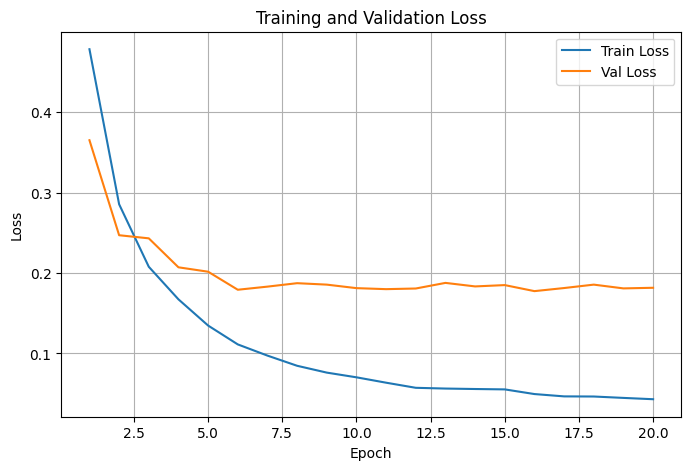

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

#######################
# 1) 데이터 로드 세팅
#######################
root_dir = "/content/drive/MyDrive/Pathology_WSI_SegDet/Warwick_filtered_Dataset"

train_img_dir  = os.path.join(root_dir, "train_new", "images")
train_msk_dir  = os.path.join(root_dir, "train_new", "masks")
testA_img_dir  = os.path.join(root_dir, "test_new", "images")
testA_msk_dir  = os.path.join(root_dir, "test_new", "masks")

train_dataset = HistopathFolderDataset(train_img_dir, train_msk_dir, resize=(512,512))
testA_dataset = HistopathFolderDataset(testA_img_dir, testA_msk_dir, resize=(512,512))

train_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=2,
    drop_last=True
)
testA_loader = DataLoader(
    testA_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=2
)

#######################
# 2) 모델 및 학습 파라미터
#######################
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)
model.classifier[4] = nn.Conv2d(256, 2, kernel_size=1)  # 2-class output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ---- LR Scheduler: ReduceLROnPlateau ----
# - patience=3: 검증 손실이 3 epoch 연속 개선되지 않으면 학습률을 factor 배로 줄임
# - factor=0.5 : 학습률을 절반으로
# - verbose=True: 줄어드는 과정을 로그로 표시
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    verbose=True
)

num_epochs = 20  # 예시: 20 epoch

#######################
# 3) 학습/검증 함수
#######################
def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)

def validate_one_epoch(model, dataloader, criterion):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            val_loss += loss.item()
    return val_loss / len(dataloader)

#######################
# 4) 학습 루프 + 손실값 기록
#######################
train_losses = []
val_losses   = []

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss   = validate_one_epoch(model, testA_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"[Epoch {epoch+1}/{num_epochs}] train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")

    # 스케줄러에 검증 손실 전달 -> 개선 안 되면 LR 감소
    scheduler.step(val_loss)

#######################
# 5) Loss 그래프 시각화
#######################
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

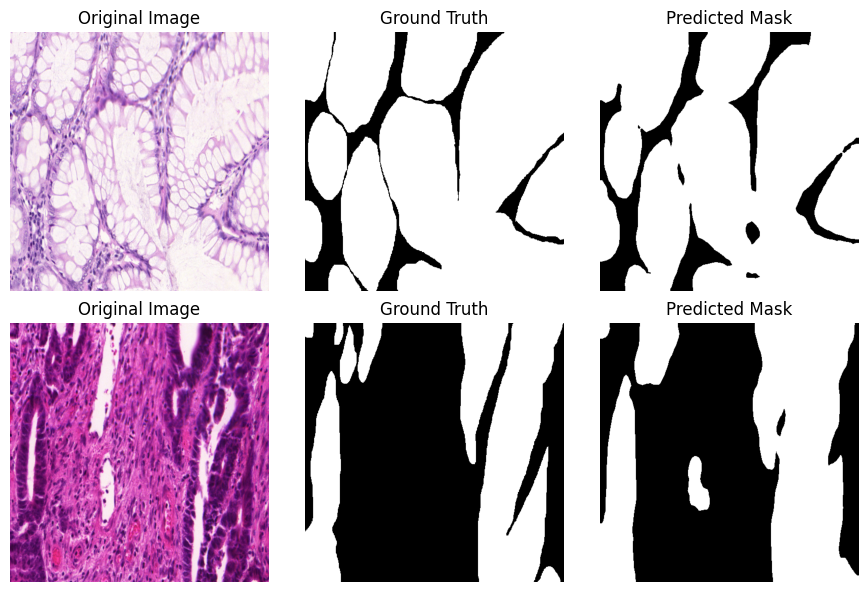

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 배치 하나를 뽑아 추론
model.eval()
images, true_masks = next(iter(testA_loader))  # 예: testA_loader
images, true_masks = images.to(device), true_masks.to(device)

with torch.no_grad():
    outputs = model(images)['out']  # (N,2,H,W) for 2-class
    preds = torch.argmax(outputs, dim=1)  # (N,H,W)

# CPU로 옮기기
images     = images.cpu()
true_masks = true_masks.cpu()
preds      = preds.cpu()

# 배치 크기
batch_size = images.size(0)

# (원본, GT, 예측) 3개씩 시각화
fig, axs = plt.subplots(batch_size, 3, figsize=(9, 3 * batch_size))

# 만약 batch_size == 1이면 axs 형태를 맞춰주기 위해
if batch_size == 1:
    axs = [axs]

for i in range(batch_size):
    # 원본 이미지: [C,H,W] -> [H,W,C] 로 변환
    image_np = np.transpose(images[i].numpy(), (1, 2, 0))  # (H,W,3)

    # 각 subplot에 이미지 배치
    axs[i][0].imshow(image_np)
    axs[i][0].set_title("Original Image")
    axs[i][0].axis('off')

    axs[i][1].imshow(true_masks[i], cmap='gray')
    axs[i][1].set_title("Ground Truth")
    axs[i][1].axis('off')

    axs[i][2].imshow(preds[i], cmap='gray')
    axs[i][2].set_title("Predicted Mask")
    axs[i][2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
save_path = "/content/drive/MyDrive/Pathology_WSI_SegDet/deeplabv3_2class.pth"
torch.save(model.state_dict(), save_path)
print("Model saved to:", save_path)

Model saved to: /content/drive/MyDrive/Pathology_WSI_SegDet/deeplabv3_2class.pth


In [ ]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) 동일 모델 구조 생성
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=False)
model.classifier[4] = nn.Conv2d(256, 2, kernel_size=1)  # 2-class output
model.to(device)

# 2) 저장했던 state_dict 불러오기
load_path = "/content/drive/MyDrive/Pathology_WSI_SegDet/deeplabv3_2class.pth"
model.load_state_dict(torch.load(load_path))
model.eval()

print("Model loaded and set to eval mode.")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
<ipython-input-27-797356ae0da7>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(to

Model loaded and set to eval mode.


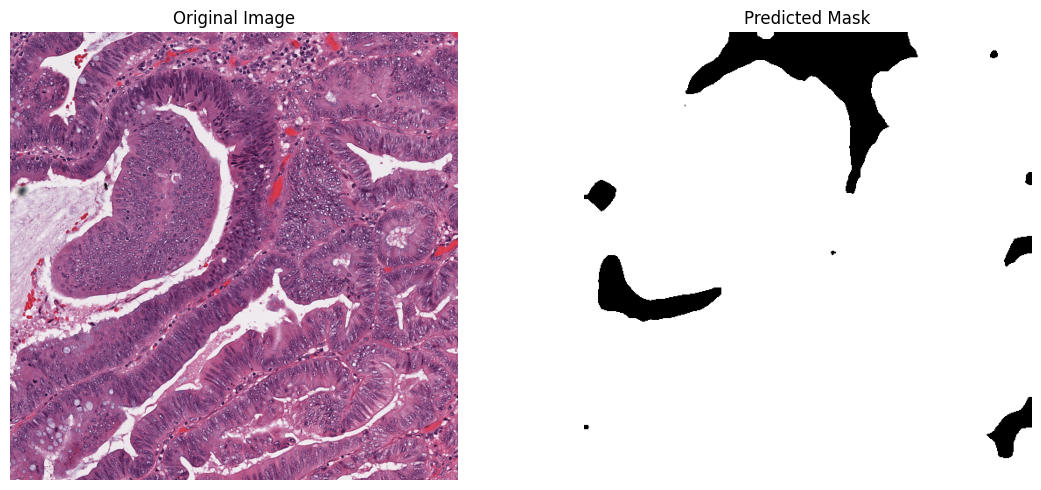

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms.functional as F

# 1) 새 이미지 경로
new_img_path = "/content/drive/MyDrive/Pathology_WSI_SegDet/new_image__/KakaoTalk_Photo_2025-01-20-20-30-49 004.png"

# 2) 이미지 로드 (PIL)
new_image = Image.open(new_img_path).convert('RGB')

# 3) 리사이즈 (학습할 때와 동일 512x512) + ToTensor
image_resized = F.resize(new_image, (512,512), Image.BILINEAR)
image_tensor  = F.to_tensor(image_resized).unsqueeze(0)  # (1,3,512,512)

image_tensor = image_tensor.to(device)

# 4) 모델 추론
with torch.no_grad():
    output = model(image_tensor)['out']  # shape=(1,2,512,512)
    pred   = torch.argmax(output, dim=1) # shape=(1,512,512), 0 or 1

pred = pred.squeeze(0).cpu().numpy()  # (512,512)

# 5) 시각화
plt.figure(figsize=(12,5))

# 원본
plt.subplot(1,2,1)
plt.imshow(new_image)
plt.title("Original Image")
plt.axis('off')

# 예측 마스크
plt.subplot(1,2,2)
plt.imshow(pred, cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.tight_layout()
plt.show()

## Quarter CROPPED new_img

In [ ]:
import os
from PIL import Image

# 입력 폴더와 출력 폴더 경로 지정
input_dir = "/content/drive/MyDrive/Pathology_WSI_SegDet/new_image__"     # 4개 원본 이미지가 있는 폴더
output_dir = "/content/drive/MyDrive/Pathology_WSI_SegDet/new_images__4x" # 4등분된 이미지가 저장될 폴더

# 출력 폴더가 없으면 생성
os.makedirs(output_dir, exist_ok=True)

# 입력 폴더 안의 파일 중 이미지 파일만 골라 리스트업
valid_exts = ('.png', '.jpg', '.jpeg', '.bmp', '.tif')
image_files = [f for f in os.listdir(input_dir)
               if f.lower().endswith(valid_exts)]

for filename in image_files:
    # 이미지 전체 경로
    filepath = os.path.join(input_dir, filename)

    # PIL.Image 로드
    with Image.open(filepath) as img:
        w, h = img.size

        # 가로/세로를 절반으로 나눈다 (2x2로 분할)
        half_w = w // 2
        half_h = h // 2

        # 각 영역 (x1, y1, x2, y2) = (왼, 위, 오른, 아래)
        # 좌상
        box1 = (0,       0,       half_w, half_h)
        # 우상
        box2 = (half_w,  0,       w,      half_h)
        # 좌하
        box3 = (0,       half_h,  half_w, h)
        # 우하
        box4 = (half_w,  half_h,  w,      h)

        sub1 = img.crop(box1)
        sub2 = img.crop(box2)
        sub3 = img.crop(box3)
        sub4 = img.crop(box4)

        # 확장자 제거한 베이스 이름
        base_name, ext = os.path.splitext(filename)

        # 각 조각을 저장 (ex: original_part1.png ...)
        sub1.save(os.path.join(output_dir, f"{filename}_part1{ext}"))
        sub2.save(os.path.join(output_dir, f"{filename}_part2{ext}"))
        sub3.save(os.path.join(output_dir, f"{filename}_part3{ext}"))
        sub4.save(os.path.join(output_dir, f"{filename}_part4{ext}"))

        print(f"Split {filename} into 4 parts.")

Split test_img_2.png into 4 parts.
Split test_img_1.png into 4 parts.
Split test_img_0.png into 4 parts.
Split test_img_3.png into 4 parts.


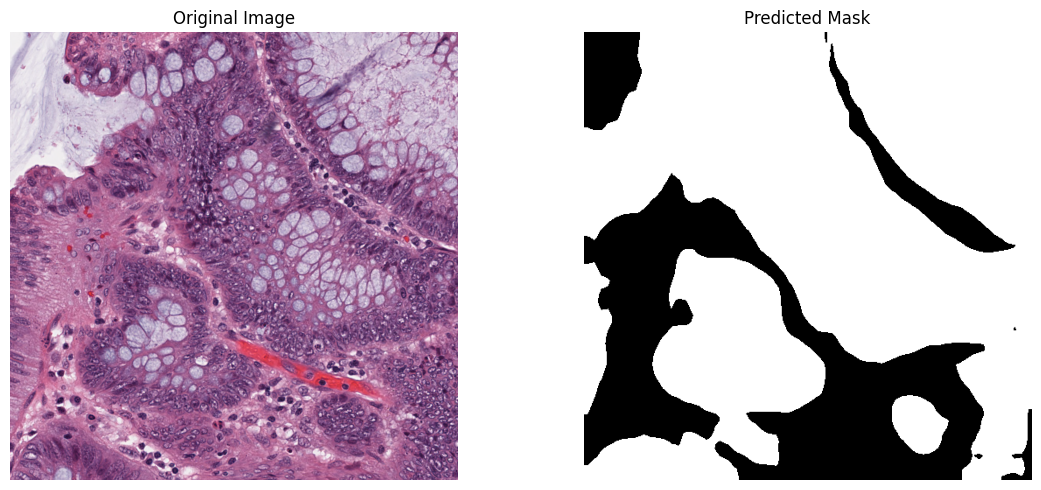

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms.functional as F

# 1) 새 이미지 경로
new_img_path = "/content/drive/MyDrive/Pathology_WSI_SegDet/new_images__4x/test_img_2.png_part2.png"

# 2) 이미지 로드 (PIL)
new_image = Image.open(new_img_path).convert('RGB')

# 3) 리사이즈 (학습할 때와 동일 512x512) + ToTensor
image_resized = F.resize(new_image, (512,512), Image.BILINEAR)
image_tensor  = F.to_tensor(image_resized).unsqueeze(0)  # (1,3,512,512)

image_tensor = image_tensor.to(device)

# 4) 모델 추론
with torch.no_grad():
    output = model(image_tensor)['out']  # shape=(1,2,512,512)
    pred   = torch.argmax(output, dim=1) # shape=(1,512,512), 0 or 1

pred = pred.squeeze(0).cpu().numpy()  # (512,512)

# 5) 시각화
plt.figure(figsize=(12,5))

# 원본
plt.subplot(1,2,1)
plt.imshow(new_image)
plt.title("Original Image")
plt.axis('off')

# 예측 마스크
plt.subplot(1,2,2)
plt.imshow(pred, cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.tight_layout()
plt.show()